#### **Endoscopy Denoising  using DCNN Framework**

In [51]:
#Imports
from __future__ import print_function
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,Activation,BatchNormalization,Add,Multiply,Concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
import datetime
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

### **Data Source**

In [52]:
H,W,CH=[120,120,3]
BATCH_SIZE=16
NOISE_LEVELS=[15,25,50] 

train_files=['Endoscopy/train/images/'+filename for filename in os.listdir('Endoscopy/train/images/')]
test_files=['Endoscopy/test/images/'+filename for filename in os.listdir('Endoscopy/test/images/')]


In [53]:
def _parse_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image_decoded=tf.image.resize(image_decoded, [H,W], method='nearest')
    image = tf.cast(image_decoded, tf.float32)/255.

    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(H,W,CH),mean=0,stddev=noise_level/255)
    noisy_image=tf.image.resize(noisy_image, [H,W], method='nearest')
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

    return noisy_image,image

### **Creating train dataset**

In [54]:
#Creating the Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(np.array(test_files))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [55]:
#data dim
iterator = iter(train_dataset)
a, b = iterator.get_next()

print('Shape of single batch of x : ',a.shape)
print('Shape of single batch of y : ',b.shape)


Shape of single batch of x :  (16, 120, 120, 3)
Shape of single batch of y :  (16, 120, 120, 3)


### **Exploratory data display**

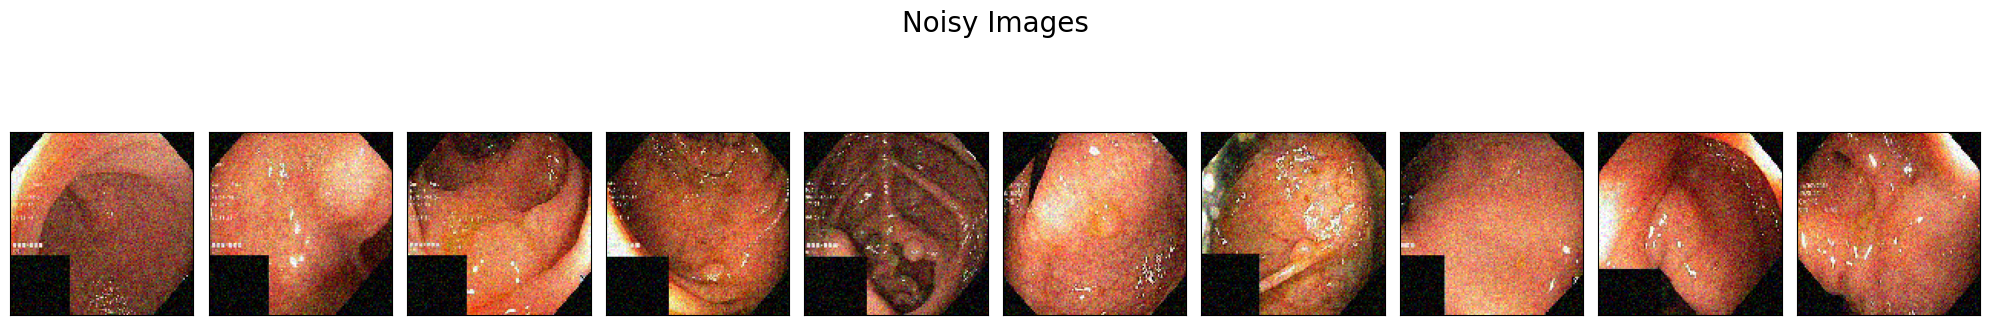

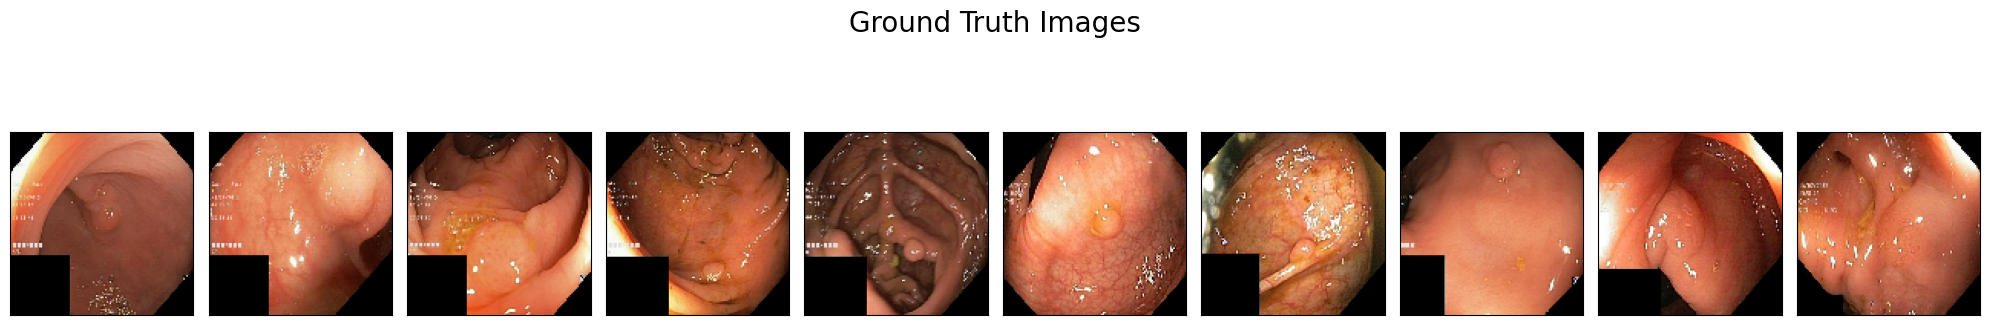

In [56]:
# Display samples

fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
    axs[i].imshow(a[i])
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    fig.suptitle('Noisy Images',fontsize=20)
fig.align_labels()     
plt.tight_layout()    
plt.show()

fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
    axs[i].imshow(b[i])
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    fig.suptitle('Ground Truth Images',fontsize=20)
fig.align_labels()     
plt.tight_layout()     
plt.show()

### **Patches creation**

In [57]:
# Image patches creation

def get_patches(file_name,patch_size,crop_sizes):
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: #We will crop the image to different sizes
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):                
                x = image_scaled[i:i+patch_size, j:j+patch_size]
                patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
    image=np.zeros(image_shape) 
    patch_size=patches.shape[1]
    p=0
    for i in range(0,image.shape[0]-patch_size+1,patch_size):
        for j in range(0,image.shape[1]-patch_size+1,patch_size):
            image[i:i+patch_size,j:j+patch_size]=patches[p] 
            p+=1
    return np.array(image)

def predict_fun(model,image_path,noise_level=30):
    patches=get_patches(image_path,H,[1])
    test_image=cv2.imread(image_path)
    patches=np.array(patches)
    ground_truth=create_image_from_patches(patches,test_image.shape)
    
    patches = patches.astype('float32') /255.
    patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
    patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
    noisy_image=create_image_from_patches(patches_noisy,test_image.shape)
    denoised_patches=model.predict(patches_noisy)
    
    denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)
    
    denoised_image=create_image_from_patches(denoised_patches,test_image.shape)
    
    return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image



### **Plot image patches**

In [58]:
#plot patches
def plot_patches(patches_noisy,denoised_patches):
    fig, axs = plt.subplots(2,10,figsize=(20,4))
    
    for i in range(10):        
        axs[0,i].imshow(patches_noisy[i])
        axs[0,i].title.set_text(' Noisy')
        axs[0,i].get_xaxis().set_visible(False)
        axs[0,i].get_yaxis().set_visible(False)
        
        axs[1,i].imshow(denoised_patches[i])
        axs[1,i].title.set_text('Denoised')
        axs[1,i].get_xaxis().set_visible(False)
        axs[1,i].get_yaxis().set_visible(False)
    plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
    fig, axs = plt.subplots(1,3,figsize=(15,15))
    axs[0].imshow(ground_truth)
    axs[0].title.set_text('Ground Truth')
    axs[1].imshow(noisy_image)
    axs[1].title.set_text('Noisy Image')
    axs[2].imshow(denoised_image)
    axs[2].title.set_text('Denoised Image')
    plt.show()



### **PSNR measure**

In [59]:
def PSNR(gt, image, max_value=1):
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))


### **RPDNET model architecture**

In [60]:
#Model
def CNN(input):
    x=Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')(input)
    x=Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')(x)
    
    y=Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')(input)
    y=Conv2D(64, (3,3), dilation_rate=5,padding='same',activation='relu')(y)
    
    z=Concatenate(axis=-1)([x,y])
    z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
    add_1=Add()([z, input])
    
    z=Conv2D(64, (3,3),padding='same',activation='relu')(add_1)
    z=Conv2D(64, (3,3),padding='same')(z)
    add_2=Add()([z,add_1])
    add_2 = Activation('relu')(add_2)
    
    z=Conv2D(64, (3,3),padding='same',activation='relu')(add_2)
    z=Conv2D(64, (3,3),padding='same',activation='relu')(z)
    z=Conv2D(64, (1,1),padding='same')(z)
    add_3=Add()([z,add_2])
    add_3 = Activation('relu')(add_3)    
    
    z = GlobalAveragePooling2D()(add_3)
    z = tf.expand_dims(z,1)
    z = tf.expand_dims(z,1)
    z=Conv2D(4, (3,3),padding='same',activation='relu')(z)
    z=Conv2D(64, (3,3),padding='same',activation='sigmoid')(z)
    mul=Multiply()([z, add_3])
    
    return mul


In [ ]:
def RPDNET():
    input = Input((H, W, CH),name='input')
    feat_extraction =Conv2D(64, (3,3),padding='same')(input)
    cnn_1=CNN(feat_extraction)
    cnn_2=CNN(cnn_1)
    cnn_3=CNN(cnn_2)
    cnn_4=CNN(cnn_3)
    x=Conv2D(3, (3,3),padding='same')(cnn_4)
    add_2=Add()([x, input])
    
    model=Model(input,add_2)
    
    return model

### **Model summary**

In [62]:
#Model train
tf.keras.backend.clear_session()
tf.random.set_seed(6908)
rpdnet = RPDNET()
rpdnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 120, 120, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 120, 120, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 concatenate_1 (Concatenate)    (None, 120, 120, 12  0           ['conv2d_14[0][0]',              
                                8)                                'conv2d_16[0][0]']              
                                                                                                  
 conv2d_17 (Conv2D)             (None, 120, 120, 64  73792       ['concatenate_1[0][0]']          
                                )                                                                 
                                                                                                  
 add_3 (Add)                    (None, 120, 120, 64  0           ['conv2d_17[0][0]',              
                                )                                 'multiply[0][0]']               
                                                                                                  
 conv2d_18

                                )                                                                 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 120, 120, 64  36928       ['activation_4[0][0]']           
                                )                                                                 
                                                                                                  
 conv2d_33 (Conv2D)             (None, 120, 120, 64  36928       ['conv2d_32[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 120, 120, 64  4160        ['conv2d_33[0][0]']              
                                )                                                                 
          

 tf.expand_dims_6 (TFOpLambda)  (None, 1, 64)        0           ['global_average_pooling2d_3[0][0
                                                                 ]']                              
                                                                                                  
 tf.expand_dims_7 (TFOpLambda)  (None, 1, 1, 64)     0           ['tf.expand_dims_6[0][0]']       
                                                                                                  
 conv2d_47 (Conv2D)             (None, 1, 1, 4)      2308        ['tf.expand_dims_7[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)             (None, 1, 1, 64)     2368        ['conv2d_47[0][0]']              
                                                                                                  
 multiply_3 (Multiply)          (None, 120, 120, 64  0           ['conv2d_48[0][0]',              
          

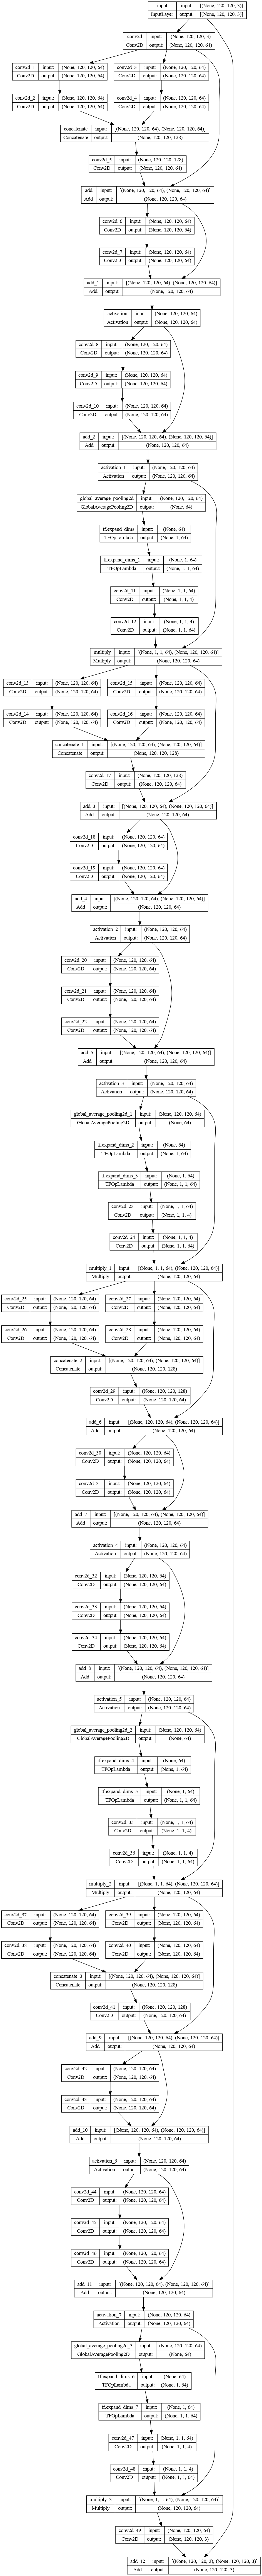

In [63]:
dot_img_file = 'rpdnet.png'
tf.keras.utils.plot_model(rpdnet, to_file=dot_img_file, show_shapes=True)


In [64]:
#Compile model
rpdnet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=['mean_absolute_error'])


###  **Set callback**

In [65]:
#Callback
def scheduler(epoch,lr):
    return lr*0.9

checkpoint_path = "rpdnet.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,verbose=0,save_best_only=False)

lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks = [cp_callback,lrScheduler]

### **Train model**

In [ ]:
#Train model
nepochs=25
history=rpdnet.fit( train_dataset,shuffle=True,epochs=nepochs,
                   validation_data= test_dataset,callbacks=callbacks,
                   max_queue_size=10,workers=1,verbose=1,
                   use_multiprocessing=True
                  )

Epoch 1/25
13/13 [==============================] - 519s 40s/step - loss: 0.0858 - mean_absolute_error: 0.0858 - val_loss: 0.1317 - val_mean_absolute_error: 0.1317 - lr: 9.0000e-04
Epoch 2/25
13/13 [==============================] - 531s 41s/step - loss: 0.0692 - mean_absolute_error: 0.0692 - val_loss: 0.1294 - val_mean_absolute_error: 0.1294 - lr: 8.1000e-04
Epoch 3/25
13/13 [==============================] - 492s 38s/step - loss: 0.0673 - mean_absolute_error: 0.0673 - val_loss: 0.1225 - val_mean_absolute_error: 0.1225 - lr: 7.2900e-04
Epoch 4/25
13/13 [==============================] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.0626 

In [ ]:
#history info.
print(history.history.keys())

### **Plot training performance**

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_history(history,['loss','val_loss'])


### **Model️ evaluation**

In [ ]:
path='Endoscopy/data/e2.jpg'
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(rpdnet,path,noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

#result
plot_predictions(ground_truth,noisy_image,denoised_image)

In [ ]:
path='Endoscopy/data/e3.jpg'
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(rpdnet,path,noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

#result
plot_predictions(ground_truth,noisy_image,denoised_image)

In [ ]:
path='Endoscopy/data/e4.jpg'
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(rpdnet,path,noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

#result
plot_predictions(ground_truth,noisy_image,denoised_image)

### **Residual learning**

In [ ]:
# Residual Learning
model_res=Model(rpdnet.input,rpdnet.get_layer('conv2d_49').output)
path='Endoscopy/data/e4.jpg'
patches_noisy,denoised_patches,ground_truth,noisy_image,residual_image=predict_fun(model_res,path,noise_level=25)


### **Residual data visualisation**

In [ ]:
#Display predicted result 
fig, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(ground_truth)
axs[0].title.set_text('Ground Truth')
axs[1].imshow(noisy_image)
axs[1].title.set_text('Noisy Image')
axs[2].imshow(residual_image)
axs[2].title.set_text('Residual Image')

plt.show()

In [ ]:
import keract
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input
from tensorflow.keras.preprocessing.image import  load_img, img_to_array

### **Activation silency map**

In [ ]:
#Activation silency map
image = load_img(path, target_size= (H, W))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
y_hat = rpdnet.predict(image)


In [ ]:
#layers
layers=['conv2d_1','conv2d_3','conv2d_2','conv2d_4']   

activations= keract.get_activations(rpdnet, image, layer_names= layers, 
                                    nodes_to_evaluate= None, output_format= 'simple',  auto_compile= True)
keract.display_activations(activations, cmap='viridis', save= False, directory= 'activations')
